In [1]:
import sys
import nltk
import numpy as np
import pandas as pd
import pickle
# from helpers import *
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
import os
from matplotlib import pyplot as plt
sys.path.append(".")
sys.path.append("..")

In [2]:
column_to_predict = "New_Assignment_Group"
classifier = "NB"  # Supported algorithms # "SVM" # "NB"
use_grid_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
use_random_search=True
remove_stop_words = True  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = False  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 1  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1

In [3]:
# loading dataset from dprep in Workbench    
# dfTickets = package.run('AllTickets.dprep', dataflow_idx=0) 

# loading dataset from csv
dfTickets = pd.read_csv(
    './datasets/all_tickets.csv',
    dtype=str
)
dfTickets

,Short description,Description,Full_Description,Assignment group,New_Assignment_Group
0,login issue,verify user detail employee manager...,login issue verify user detail employee ...,GRP_0,0
1,outlook,receive hello team meeting sk...,outlook receive hello team meeti...,GRP_0,0
2,can not log vpn,receive hi can not log vpn ...,can not log vpn receive hi can no...,GRP_0,0
3,unable access hr tool page,unable access hr tool page,unable access hr tool page unable access hr to...,GRP_0,0
4,skype error,skype error,skype error skype error,GRP_0,0
...,...,...,...,...,...
7813,email not come in from zz mail,receive good afternoon i be not...,email not come in from zz mail receive ...,GRP_29,22
7814,telephony software issue,telephony software issue,telephony software issue telephony software issue,GRP_0,0
7815,vip windows password reset for tifpdchb ped...,vip window password reset for tifpdchb ped...,vip windows password reset for tifpdchb ped...,GRP_0,0
7816,machine n o est funcionando,i be unable to access the machine utility to f...,machine n o est funcionando i be unable t...,GRP_62,44


In [4]:
text_columns = "Full_Description"  # "title" - text columns used for TF-IDF

# Removing rows related to classes represented by low amount of data
print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: "+str(dfTickets.shape))
print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: "+str(len(np.unique(dfTickets[column_to_predict]))))
bytag = dfTickets.groupby(column_to_predict).aggregate(np.count_nonzero)
tags = bytag[bytag.Full_Description > min_data_per_class].index
dfTickets = dfTickets[dfTickets[column_to_predict].isin(tags)]
print(
    "Shape of dataset after removing classes with less then "
    + str(min_data_per_class) + " rows: "
    + str(dfTickets.shape)
)
print(
    "Number of classes after removing classes with less then "
    + str(min_data_per_class) + " rows: "
    + str(len(np.unique(dfTickets[column_to_predict])))
)

Shape of dataset before removing classes with less then 1 rows: (7818, 5)
Number of classes before removing classes with less then 1 rows: 50
Shape of dataset after removing classes with less then 1 rows: (7818, 5)
Number of classes after removing classes with less then 1 rows: 50


In [5]:
labelData = dfTickets[column_to_predict]
data = dfTickets[text_columns]

# Split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labelData, test_size=0.2,random_state=42
)  # split data to train/test sets with 80:20 ratio

In [6]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [7]:
# Count vectorizer
if remove_stop_words:
    count_vect = CountVectorizer(stop_words=stop_words_lang)
elif use_stemming:
    count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
else:
    count_vect = CountVectorizer()

vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(6254, 11497)

In [8]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(6254, 11497)

In [9]:
# Fitting the training data into a data processing pipeline and eventually into the model itself
if classifier == "NB":
    print("Training NB classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(fit_prior=fit_prior))
    ])
    text_clf = text_clf.fit(train_data, train_labels)
    
    
    #print("RandomForestClassifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

Training NB classifier


In [12]:
if use_grid_search:
    # Grid Search
    # Here, we are creating a list of parameters for which we would like to do performance tuning.
    # All the parameters name start with the classifier name (remember the arbitrary name we gave).
    # E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

    # NB parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'clf__alpha': (1e-2, 1e-3)
    }

    # Next, we create an instance of the grid search by passing the classifier, parameters
    # and n_jobs=-1 which tells to use multiple cores from user machine.
    gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(train_data, train_labels)

In [13]:
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [15]:
print("Evaluating model")
# Score and evaluate model on test data using model without hyperparameter tuning
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))

# Score and evaluate model on test data using model WITH hyperparameter tuning
if use_grid_search:
    predicted = gs_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix with GridSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean with GridSearch: " + str(prediction_acc))


Evaluating model
Confusion matrix without GridSearch:
[[691   0   0 ...   0   0   0]
 [  4   0   0 ...   0   0   0]
 [ 16   0   0 ...   0   0   0]
 ...
 [  5   0   0 ...   0   0   0]
 [ 17   0   0 ...   0   0   0]
 [  5   0   0 ...   0   0   0]]
Mean without GridSearch: 0.5415601023017903
Confusion matrix with GridSearch:
[[628   0   0 ...   0   5   1]
 [  1   2   0 ...   0   0   0]
 [  2   0   8 ...   0   0   0]
 ...
 [  3   0   0 ...   1   0   0]
 [ 12   0   0 ...   0   3   0]
 [  4   0   0 ...   0   0   1]]
Mean with GridSearch: 0.659846547314578


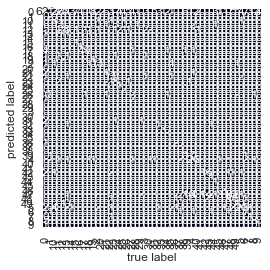

In [16]:
# Ploting confusion matrix with 'seaborn' module
# Use below line only with Jupyter Notebook
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')
# Save confusion matrix to outputs in Workbench
# plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
plt.show()

In [17]:
testing = gs_clf.predict(['india         s access sw    and sw    go down at        pm et on         india         s access sw    and sw    go down at     '])
print(testing)

['47']


In [19]:
filename = 'finalized_model.sav'
pickle.dump(gs_clf, open(filename, 'wb'))

In [1]:
pigar

NameError: name 'pigar' is not defined